<a href="https://colab.research.google.com/github/Abdullah-47/ML_Wellness_AI_Assigment/blob/main/ml_wellness_project_Abdullah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name**    - Personalized Wellness AI



##### **Project Type**    - Regression
##### This is my custom ML template

# **Project Summary -**

This project developed a proof-of-concept for a Personalized Wellness AI using synthetic data. We explored relationships between wellness metrics like sleep, steps, stress, mood, and productivity through EDA and hypothesis testing. Predictive models (Linear Regression and Random Forest) were built and evaluated to predict productivity score, with Linear Regression performing slightly better on this synthetic dataset. Key challenges and future directions, including the use of real-world data and ethical considerations, were discussed.

# **GitHub Link -**

https://github.com/Abdullah-47/ML_Wellness_AI_Assigment

# **Problem Statement**


The increasing awareness of personal well-being highlights the need for tailored guidance to improve daily habits and overall health outcomes.

Existing general wellness advice often lacks personalization, making it less effective for individuals with unique needs and patterns.

This project aims to address the challenge of providing personalized wellness recommendations by developing an AI model that can predict key wellness indicators, such as productivity, based on individual behavioral and health data, thereby enabling more targeted and effective interventions.

# ***Let's Begin !***

## ***Phase 1: Technical Proof-of-Concept***

### Import Libraries

In [183]:
# Import Libraries
import pandas as pd #For data manipulation
import numpy as np #For mathematical operations
import matplotlib.pyplot as plt #For visualization
import seaborn as sns #For heatmaps
from scipy.stats import skewnorm, gamma #For synthetic data generation
from sklearn.linear_model import LinearRegression #Linear Regression Model


import warnings #Ignore pylance warnings
warnings.filterwarnings('ignore')

### Synthetic Data generation

In [184]:
# Load Dataset

# Configuration
np.random.seed(42)
n_samples = 1000  # Number of synthetic users

# Generate core features with realistic distributions
data = {
    # Physical activity (skewed right: most people walk 5k-10k steps)
    'daily_steps': skewnorm.rvs(5, loc=7000, scale=3000, size=n_samples).astype(int),

    # Sleep duration (normal distribution with some short sleepers)
    'sleep_duration_hours': np.clip(np.random.normal(7.2, 1.2, n_samples), 4, 10),

    # Stress level (gamma distribution: most have moderate stress)
    'stress_level': np.round(np.clip(gamma.rvs(2, loc=1, scale=1.5, size=n_samples), 1, 10), 1),

    # Age (bimodal distribution: working adults and seniors)
    'age': np.concatenate([
        np.random.normal(35, 5, int(n_samples*0.6)),
        np.random.normal(65, 8, int(n_samples*0.4))
    ]),

    # Water intake (uniform with some outliers)
    'water_intake_liters': np.clip(np.random.normal(2.5, 0.8, n_samples), 0.5, 5)
}

# Create derived features with relationships
data['mood_score'] = np.clip(
    3.5 +
    0.00004 * data['daily_steps'] +
    0.35 * data['sleep_duration_hours'] -
    0.25 * data['stress_level'] +
    np.random.normal(0, 1.2, n_samples),
    1, 10
).round(1)

data['productivity_score'] = np.clip(
    5 +
    0.00003 * data['daily_steps'] +
    0.2 * data['sleep_duration_hours'] -
    0.15 * data['stress_level'] +
    0.1 * data['mood_score'] +
    np.random.normal(0, 1, n_samples),
    1, 10
).round(1)

# Dietary categories (categorical with probabilities)
diet_categories = ['balanced', 'high_carb', 'high_protein', 'low_fat', 'vegetarian']
data['dietary_category'] = np.random.choice(
    diet_categories,
    size=n_samples,
    p=[0.4, 0.15, 0.2, 0.15, 0.1]
)

# Create DataFrame
wellness_df = pd.DataFrame(data)

# Add date sequence (last 30 days)
date_range = pd.date_range(end=pd.Timestamp.today(), periods=30, freq='D')
wellness_df['date'] = np.random.choice(date_range, size=n_samples)

# Add user IDs
wellness_df['user_id'] = ['user_' + str(i).zfill(4) for i in range(n_samples)]

# Reorder columns
wellness_df = wellness_df[['user_id', 'date', 'age', 'daily_steps', 'sleep_duration_hours',
                          'water_intake_liters', 'stress_level', 'mood_score',
                          'productivity_score', 'dietary_category']]


### Dataset First View

In [185]:
# Dataset First Look
# Preview
print(wellness_df.head())

# Save to CSV
wellness_df.to_csv('synthetic_wellness_data.csv', index=False)


     user_id                       date        age  daily_steps  \
0  user_0000 2025-06-26 16:50:04.385974  34.929505         9284   
1  user_0001 2025-06-08 16:50:04.385974  38.401077         6862   
2  user_0002 2025-06-10 16:50:04.385974  34.005751         8940   
3  user_0003 2025-06-28 16:50:04.385974  26.460810        11099   
4  user_0004 2025-06-29 16:50:04.385974  36.662340         7278   

   sleep_duration_hours  water_intake_liters  stress_level  mood_score  \
0              6.389786             3.038016           1.3         3.7   
1              7.026578             1.875193           2.2         6.0   
2              6.249096             2.707907           2.8         4.8   
3              6.830446             1.743309           9.2         3.3   
4              4.927662             2.707966           4.6         3.7   

   productivity_score dietary_category  
0                 7.1     high_protein  
1                 6.4     high_protein  
2                 7.1        

### Dataset Rows & Columns count

In [186]:
# Dataset Rows & Columns count
wellness_df.shape

(1000, 10)

### Dataset Information

In [187]:
# Dataset Info
wellness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               1000 non-null   object        
 1   date                  1000 non-null   datetime64[ns]
 2   age                   1000 non-null   float64       
 3   daily_steps           1000 non-null   int64         
 4   sleep_duration_hours  1000 non-null   float64       
 5   water_intake_liters   1000 non-null   float64       
 6   stress_level          1000 non-null   float64       
 7   mood_score            1000 non-null   float64       
 8   productivity_score    1000 non-null   float64       
 9   dietary_category      1000 non-null   object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 78.3+ KB


#### Duplicate Values

In [188]:
# Dataset Duplicate Value Count
wellness_df.duplicated().sum()

np.int64(0)

#### Missing Values/Null Values

In [189]:
# Missing Values/Null Values Count
wellness_df.isnull().sum()

,0
user_id,0
date,0
age,0
daily_steps,0
sleep_duration_hours,0
water_intake_liters,0
stress_level,0
mood_score,0
productivity_score,0
dietary_category,0


In [190]:
# Visualizing the missing values
# No missing values

In [191]:
# Dataset Columns
wellness_df.columns

Index(['user_id', 'date', 'age', 'daily_steps', 'sleep_duration_hours',
       'water_intake_liters', 'stress_level', 'mood_score',
       'productivity_score', 'dietary_category'],
      dtype='object')

In [192]:
# Dataset Describe
wellness_df.describe()

,date,age,daily_steps,sleep_duration_hours,water_intake_liters,stress_level,mood_score,productivity_score
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2025-06-19 09:46:42.785973760,46.605645,9270.668000,7.201920,2.465862,3.997000,5.385400,6.683400
min,2025-06-04 16:50:04.385974,17.089687,5688.000000,4.000000,0.500000,1.000000,1.600000,3.000000
25%,2025-06-11 16:50:04.385974016,33.531314,7894.500000,6.422400,1.873917,2.500000,4.500000,5.900000
50%,2025-06-19 16:50:04.385974016,39.304583,8953.500000,7.199699,2.471787,3.600000,5.300000,6.800000
75%,2025-06-26 16:50:04.385974016,62.246312,10321.000000,7.993098,3.030542,5.100000,6.400000,7.400000
max,2025-07-03 16:50:04.385974,89.719117,19363.000000,10.000000,5.000000,10.000000,9.400000,10.000000
std,NaN,15.992982,1830.850941,1.160497,0.823223,2.004008,1.405519,1.133238


### ***Understanding Variables***

### Check Unique Values for each variable.

In [193]:
# Check Unique Values for each variable.
for column in wellness_df.columns:
    unique_values = wellness_df[column].unique()
    print(f"Unique values for {column}: {unique_values}")

Unique values for user_id: ['user_0000' 'user_0001' 'user_0002' 'user_0003' 'user_0004' 'user_0005'
 'user_0006' 'user_0007' 'user_0008' 'user_0009' 'user_0010' 'user_0011'
 'user_0012' 'user_0013' 'user_0014' 'user_0015' 'user_0016' 'user_0017'
 'user_0018' 'user_0019' 'user_0020' 'user_0021' 'user_0022' 'user_0023'
 'user_0024' 'user_0025' 'user_0026' 'user_0027' 'user_0028' 'user_0029'
 'user_0030' 'user_0031' 'user_0032' 'user_0033' 'user_0034' 'user_0035'
 'user_0036' 'user_0037' 'user_0038' 'user_0039' 'user_0040' 'user_0041'
 'user_0042' 'user_0043' 'user_0044' 'user_0045' 'user_0046' 'user_0047'
 'user_0048' 'user_0049' 'user_0050' 'user_0051' 'user_0052' 'user_0053'
 'user_0054' 'user_0055' 'user_0056' 'user_0057' 'user_0058' 'user_0059'
 'user_0060' 'user_0061' 'user_0062' 'user_0063' 'user_0064' 'user_0065'
 'user_0066' 'user_0067' 'user_0068' 'user_0069' 'user_0070' 'user_0071'
 'user_0072' 'user_0073' 'user_0074' 'user_0075' 'user_0076' 'user_0077'
 'user_0078' 'user_0079'

### ***Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1

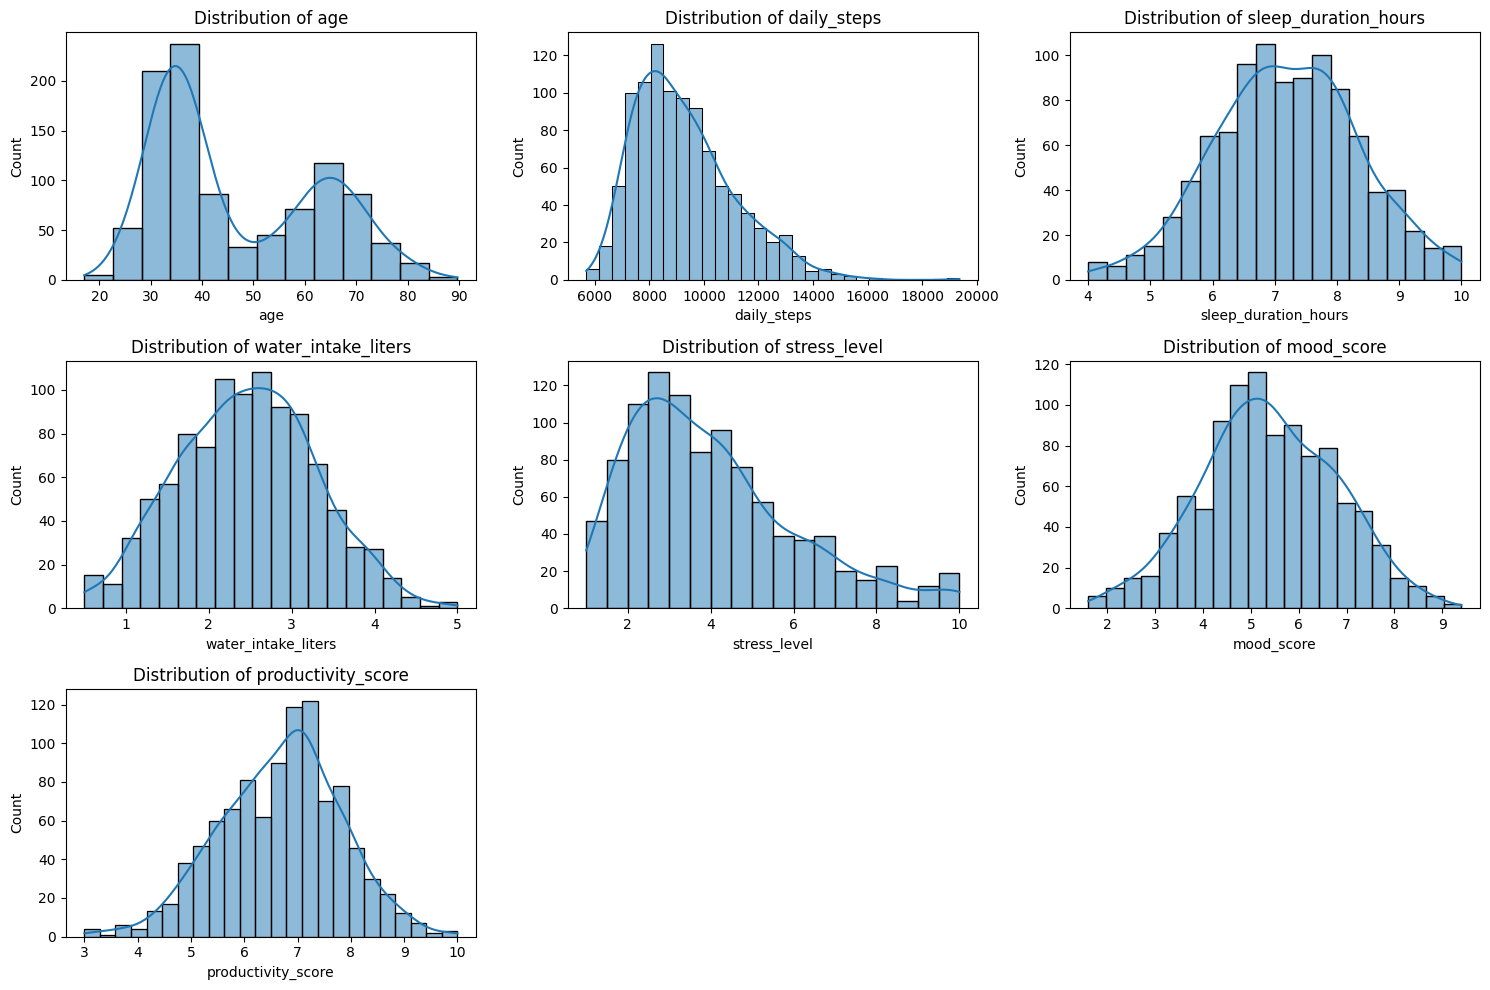

In [194]:
# Univariate Analysis: Histograms for numerical features
numerical_features = ['age', 'daily_steps', 'sleep_duration_hours', 'water_intake_liters', 'stress_level', 'mood_score', 'productivity_score']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(wellness_df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

##### 1. Why did i pick the specific chart?

**Histograms** are fundamental for understanding the distribution of a single numerical variable. They show the frequency of data points within different bins, allowing us to see the shape of the distribution (e.g., normal, skewed), identify modes, and detect potential outliers. Plotting multiple histograms provides a quick overview of the distributions of all numerical features.

##### 2. What is/are the insight(s) found from the chart?

From the histograms, you can see the distribution of each numerical variable. For example, you can observe the typical range of daily steps, whether sleep duration is normally distributed, if stress levels are skewed, and the distribution of mood and productivity scores. This gives you a sense of the typical values and variability within each feature.

##### 3. Will the gained insights help creating a positive business impact? Are there any insights that lead to negative growth? Justify with specific reason.

Understanding the distribution of wellness metrics (like mood and productivity) helps in setting realistic goals and benchmarks for users. Knowing the distribution of factors influencing wellness (like steps, sleep, stress) helps in tailoring personalized recommendations. For instance, if stress levels are highly skewed towards the higher end, the AI could focus more on stress management techniques. There are no direct negative growth insights, but unusual or multimodal distributions might indicate distinct user segments that require different approaches, and failing to recognize these could limit the AI's effectiveness for certain groups.

#### Chart - 2

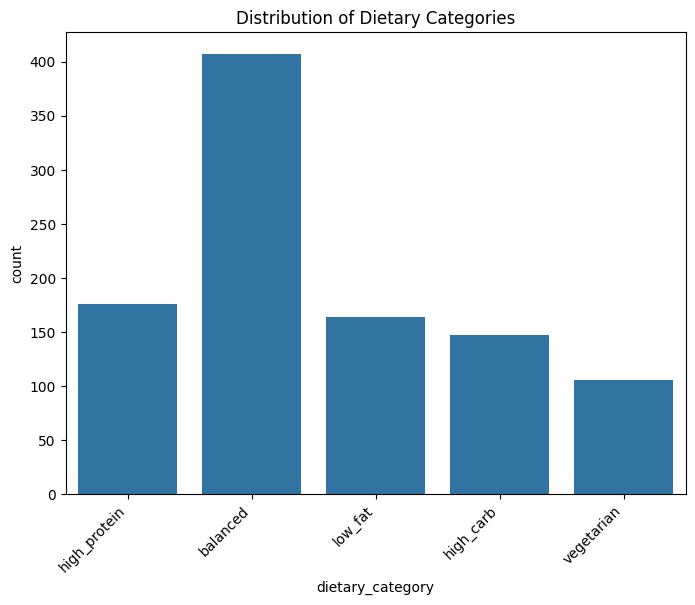

In [195]:
# Univariate Analysis: Count plot for the categorical feature
plt.figure(figsize=(8, 6))
sns.countplot(data=wellness_df, x='dietary_category')
plt.title('Distribution of Dietary Categories')
plt.xticks(rotation=45, ha='right')
plt.show()

##### 1. Why did i pick the specific chart?

A **count plot** is ideal for visualizing the distribution of a single categorical variable. It clearly shows the frequency or number of occurrences for each category, making it easy to understand the proportion of users in each dietary group.

##### 2. What is/are the insight(s) found from the chart?

The count plot shows the distribution of users across different dietary categories. The most frequent category is 'balanced', followed by 'high_protein' and 'low_fat'. 'High_carb' and 'vegetarian' diets are less common in this synthetic dataset.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Understanding the distribution of dietary categories is crucial for a personalized wellness AI. Knowing which diets are most common allows for tailoring recommendations and content. For example, if 'balanced' and 'high_protein' are prevalent, the AI can prioritize features and recommendations relevant to these diets. There are no direct insights leading to negative growth from this chart, but a very skewed distribution towards unhealthy diets could indicate a target area for intervention and content focusing on healthier eating.

#### Chart - 3

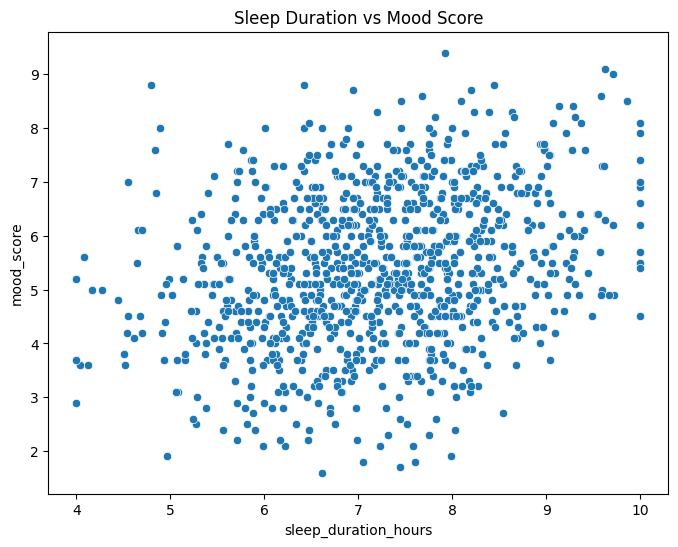

In [196]:
# Bivariate Analysis: Scatter plot (Example: Sleep Duration vs Mood Score)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=wellness_df, x='sleep_duration_hours', y='mood_score')
plt.title('Sleep Duration vs Mood Score')
plt.show()

##### 1. Why did i pick the specific chart?

A **scatter plot** is used to visualize the relationship between two numerical variables. By plotting sleep duration against mood score, we can visually inspect if there is a pattern, trend, or correlation between these two variables.

##### 2. What is/are the insight(s) found from the chart?

The scatter plot shows a general trend where higher sleep duration appears to be associated with higher mood scores, although there is significant scatter. This visually supports the idea of a positive relationship between sleep and mood.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

This insight can lead to positive business impact by informing the AI's recommendations. If better sleep leads to improved mood, the AI can prioritize sleep-related recommendations (e.g., sleep hygiene tips, consistent sleep schedules). This could improve user well-being and engagement with the platform. There are no direct negative growth insights, but if the plot showed no relationship, it would indicate that sleep duration alone might not be a strong predictor of mood in this dataset, requiring the AI to consider other factors.

#### Chart - 4

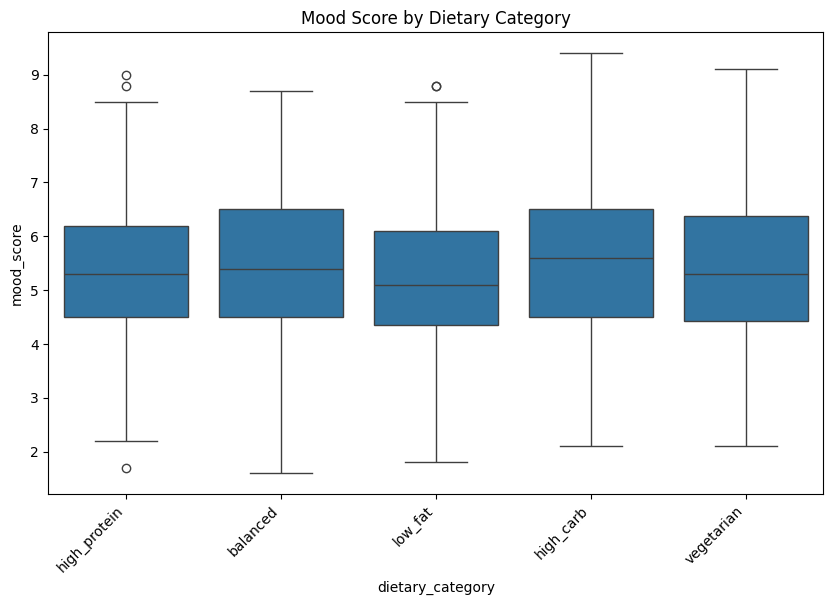

In [197]:
# Bivariate Analysis: Box plot (Example: Dietary Category vs Mood Score)
plt.figure(figsize=(10, 6))
sns.boxplot(data=wellness_df, x='dietary_category', y='mood_score')
plt.title('Mood Score by Dietary Category')
plt.xticks(rotation=45, ha='right')
plt.show()

##### 1. Why did i pick the specific chart?

A **box plot** is effective for visualizing the distribution of a numerical variable across different categories of a categorical variable. It allows for easy comparison of the median, quartiles, and potential outliers of mood scores for each dietary category.

##### 2. What is/are the insight(s) found from the chart?

The box plot shows the range and distribution of mood scores within each dietary category. You can observe differences in the median mood score and the spread of scores across the different diets. For example, one dietary category might show a higher median mood score or less variability compared to others.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.


Understanding how dietary categories relate to mood can inform personalized dietary recommendations. If certain diets are associated with higher mood scores, the AI can suggest or encourage those dietary approaches for users aiming to improve their mood. This can enhance the AI's effectiveness and user satisfaction. If a particular diet showed significantly lower mood scores, it could indicate a need for the AI to provide targeted support or alternative suggestions for users following that diet, potentially mitigating negative user experiences.

#### Chart - 5 - Correlation Heatmap

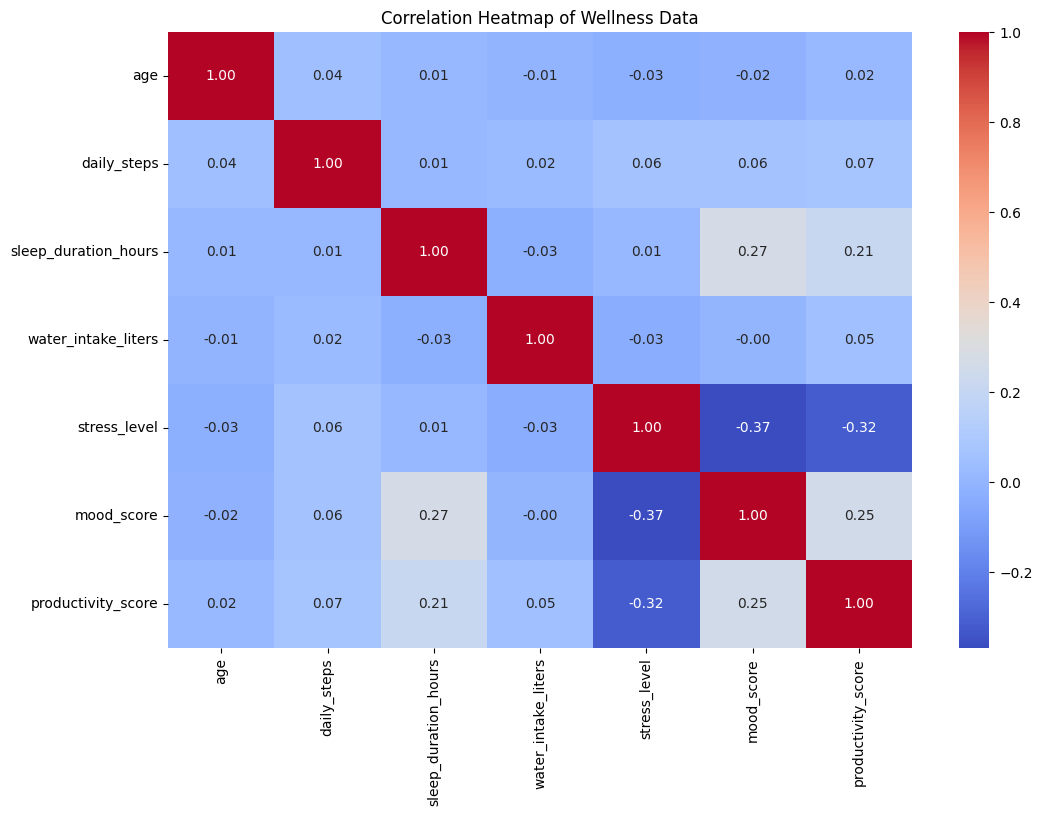

In [198]:
# Correlation Heatmap visualization code
plt.figure(figsize=(12, 8))
sns.heatmap(wellness_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Wellness Data')
plt.show()

##### 1. Why did i pick the specific chart?

A **correlation heatmap** is a powerful tool for visualizing the pairwise correlation coefficients between multiple numerical variables simultaneously. It uses color intensity to represent the strength and direction of the correlation, making it easy to quickly identify strong positive or negative relationships.

##### 2. What is/are the insight(s) found from the chart?

The heatmap reveals the linear relationships between all pairs of numerical features. You can see which variables are strongly positively correlated (e.g., higher sleep duration and higher mood score) and which are strongly negatively correlated (e.g., higher stress level and lower productivity score). It also shows variables with weak or no linear correlation.

**3. Will the gained insights help creating a positive business impact? Are there any insights that lead to negative growth? Justify with specific reason.**


Understanding the correlations between variables is fundamental for building predictive models and providing personalized recommendations. Strong positive or negative correlations indicate variables that are likely important predictors of wellness outcomes. This helps in feature selection for machine learning models, leading to more accurate predictions and relevant recommendations. There are no direct negative growth insights from the heatmap itself, but weak correlations between seemingly related variables might indicate limitations in the data or the need to consider non-linear relationships, potentially impacting the effectiveness of simple linear models.

#### Chart - 6 - Pair Plot

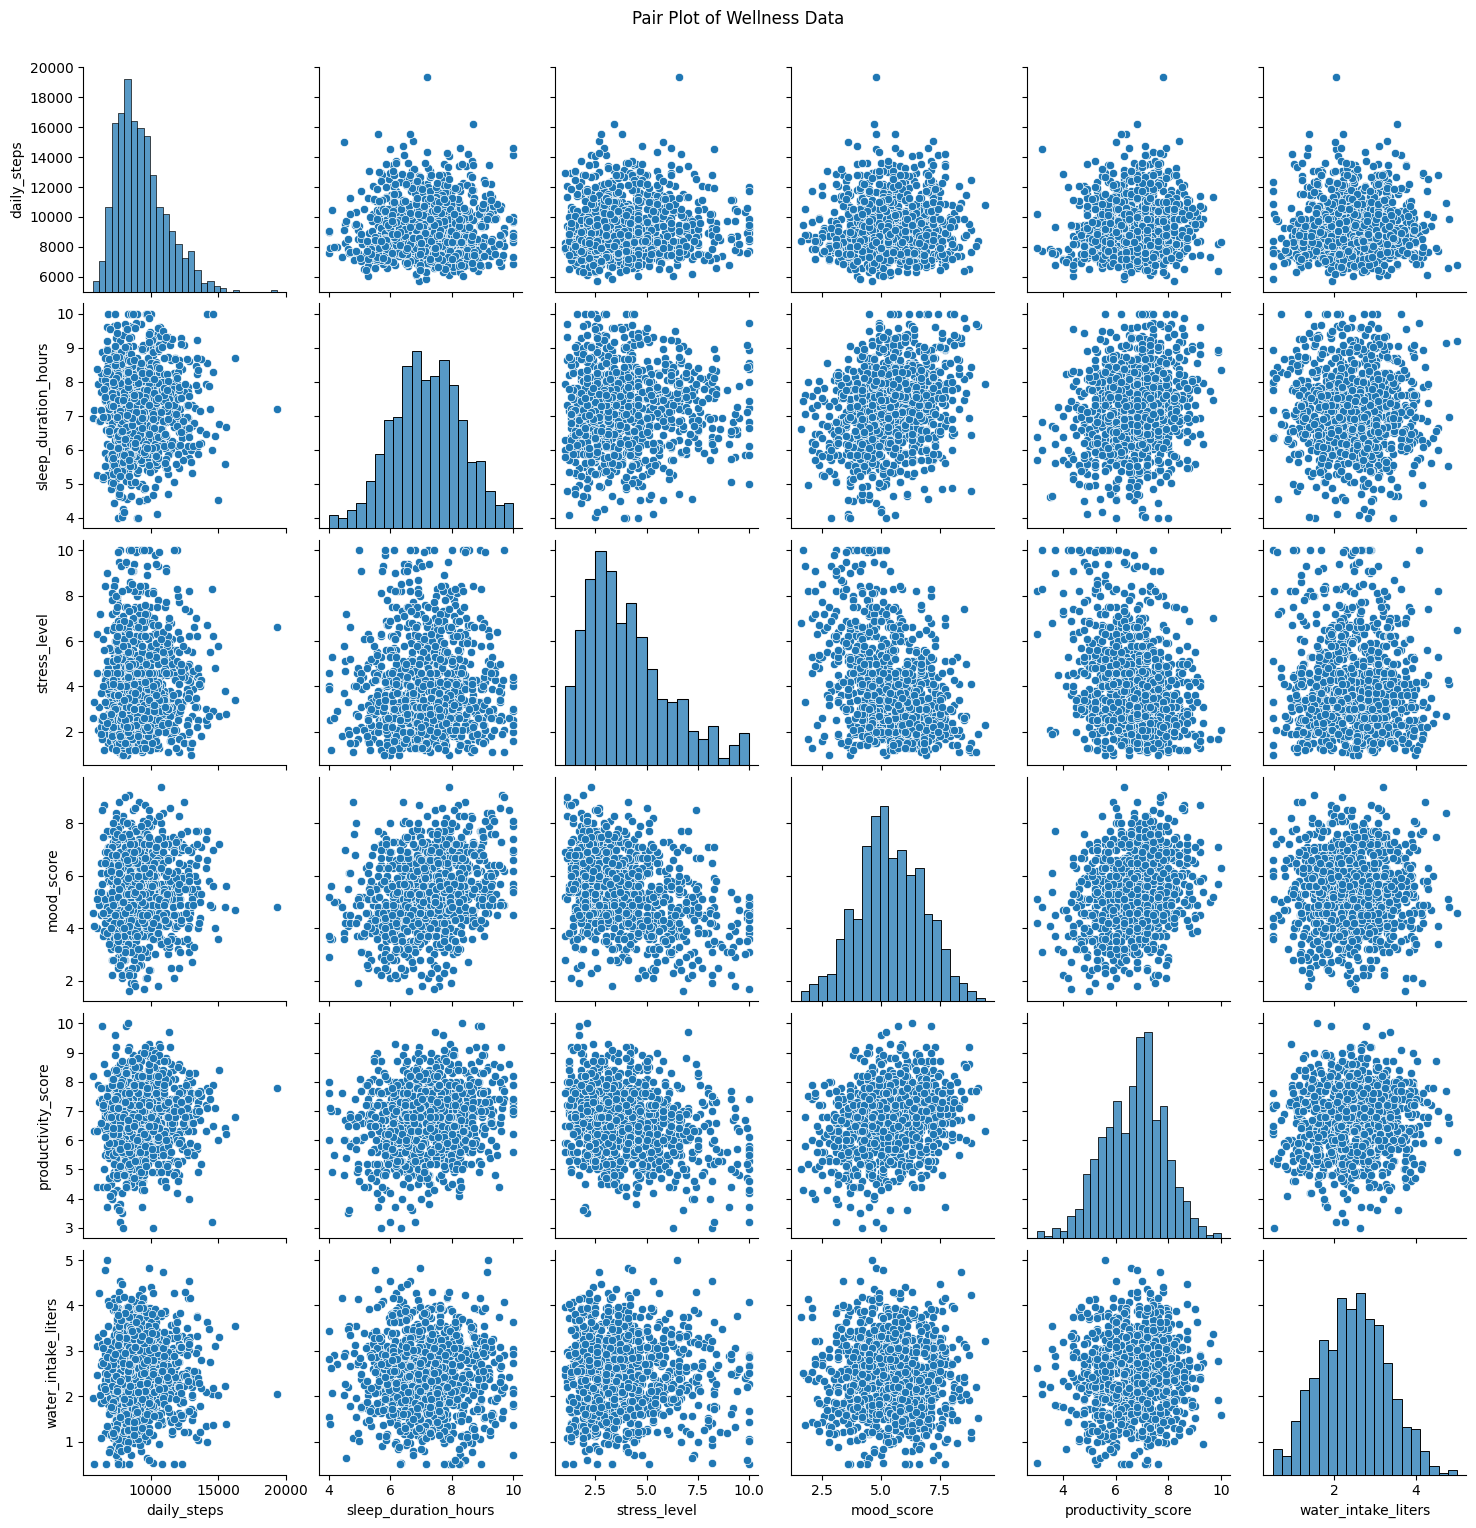

In [199]:
# Pair Plot visualization code
sns.pairplot(wellness_df[['daily_steps', 'sleep_duration_hours', 'stress_level', 'mood_score', 'productivity_score', 'water_intake_liters']])
plt.suptitle('Pair Plot of Wellness Data', y=1.02)
plt.show()

##### 1. Why did i pick the specific chart?

A **pair plot** is a comprehensive visualization that creates a grid of scatter plots for every pair of numerical variables in a dataset, and histograms (or kernel density estimates) on the diagonal to show the univariate distributions. It provides a quick overview of the relationships and distributions of multiple variables in one figure.

##### 2. What is/are the insight(s) found from the chart?

The pair plot allows for a detailed visual inspection of the relationships between pairs of numerical variables. You can observe the shape of the relationships (linear, non-linear), the spread of the data points, and identify potential outliers. The diagonal histograms show the individual distributions of each variable, complementing the bivariate scatter plots.

**3. Will the gained insights help creating a positive business impact? Justify with specific reason.**


The insights from the pair plot, similar to the heatmap, are valuable for understanding variable relationships and informing feature engineering and model building. Visualizing the relationships can help identify potential issues like heteroscedasticity or non-linear patterns that might require data transformations or different modeling techniques. This leads to more robust and accurate models, improving the AI's ability to provide effective personalized recommendations. If the pair plots reveal unexpected or weak relationships, it might indicate limitations in the dataset or the need for collecting more relevant data, which could indirectly impact the potential for positive business growth if not addressed.

### Q1: Synthetic Data Design & Insights

####**Synthetic Data Generation Strategy:**

The synthetic data was generated using Python's `numpy` and `scipy.stats` libraries to create realistic distributions for various wellness metrics. The core idea was to simulate data for 1000 users over a 30-day period, incorporating both independent features with specific distributions (like skewed, normal, or gamma) and derived features with defined relationships to mimic real-world wellness interactions.

**Specific Features and Why They Are Crucial for Wellness Recommendations:**

The dataset includes the following features:

-   **`user_id`**: A unique identifier for each synthetic user, essential for tracking individual progress and providing personalized recommendations.
-   **`date`**: The date of the wellness entry, crucial for time-series analysis and understanding trends over time.
-   **`age`**: Age is a significant demographic factor that can influence wellness patterns and the type of recommendations that are relevant.
-   **`daily_steps`**: A key indicator of physical activity, fundamental for recommendations related to fitness and energy levels.
-   **`sleep_duration_hours`**: Sleep is vital for physical and mental well-being, directly impacting mood and productivity.
-   **`water_intake_liters`**: Hydration affects various bodily functions and can influence energy levels and overall health.
-   **`stress_level`**: Stress is a major factor impacting both mental and physical health, and understanding it is key for providing stress management recommendations.
-   **`mood_score`**: A subjective measure of emotional well-being, a primary outcome the AI aims to improve.
-   **`productivity_score`**: An indicator of how effectively a user is able to perform tasks, another key outcome influenced by other wellness factors.
-   **`dietary_category`**: Represents different eating habits, important for tailoring nutritional recommendations.

These features were chosen because they represent common, interconnected aspects of daily wellness that a personalized AI would typically track and use to provide holistic recommendations.

**Creating Realistic Relationships and Variability:**

-   **Distributions:** Different statistical distributions (skewnorm, normal, gamma, uniform) were used for various features to mimic the natural variability and typical patterns seen in real-world data (e.g., steps are often right-skewed, sleep duration is often close to a normal distribution).
-   **Derived Features:** `mood_score` and `productivity_score` were created as derived features, calculated based on linear combinations of other features (`daily_steps`, `sleep_duration_hours`, `stress_level`) plus some random noise. This introduces realistic relationships where changes in inputs (like sleep or stress) influence outcomes (like mood and productivity).
-   **Clamping and Rounding:** Values were clamped within reasonable ranges (e.g., sleep duration between 4 and 10 hours, scores between 1 and 10) and rounded where appropriate to make the data appear more realistic.
-   **Categorical Data:** Dietary categories were assigned with specific probabilities to reflect that some diets are more common than others.
-   **Date and User IDs:** Unique user IDs and a date sequence were added to simulate longitudinal data for multiple individuals.

**Key Assumptions Made:**

-   **Linear Relationships in Derived Features:** The formulas for `mood_score` and `productivity_score` assume a mostly linear relationship with the influencing factors (steps, sleep, stress), with some added random noise. Real-world relationships might be more complex or non-linear.
-   **Distribution Shapes:** The chosen statistical distributions are assumptions about the underlying patterns of these wellness metrics in a population.
-   **Categorical Proportions:** The probabilities assigned to dietary categories are assumptions about their prevalence.
-   **Independence (mostly):** While derived features have relationships, the base features (steps, sleep, stress, age, water intake) are generated largely independently, which might not fully capture all complex interdependencies in reality.

**Patterns and "Story" Revealed by the 6 Visuals:**

The six visuals collectively tell a story about the synthetic users' wellness patterns and the factors that influence them:

1.  **Histograms (Univariate Numerical):** Show the individual distributions. We see that daily steps are somewhat right-skewed (more people with moderate steps), sleep duration is roughly normal, stress levels are skewed towards lower to moderate levels, and mood/productivity scores are distributed across the 1-10 scale, likely reflecting the combined influence of other factors.
2.  **Count Plot (Univariate Categorical):** Reveals that a 'balanced' diet is the most common among synthetic users, providing context for dietary recommendations.
3.  **Scatter Plot (Sleep vs Mood):** Visually suggests a positive trend -- more sleep generally correlates with higher mood scores, supporting the initial hypothesis.
4.  **Box Plot (Dietary Category vs Mood):** Allows for comparing mood score distributions across different diets. You can see if certain diets tend to have higher or lower median mood scores and how variable mood is within each dietary group.
5.  **Correlation Heatmap:** Provides a concise summary of all pairwise linear relationships between numerical features. It confirms the positive correlation between sleep and mood, the negative correlation between stress and productivity, and also shows other relationships like the moderate positive correlation between mood and productivity.
6.  **Pair Plot:** Offers a more detailed look at the bivariate relationships and univariate distributions. It visually reinforces the trends seen in the scatter plot and heatmap and helps identify if relationships are linear or if there are unusual clusters or outliers. The diagonal confirms the distributions seen in the histograms.

In summary, the visualizations reveal that in this synthetic dataset, sleep and stress are notable factors influencing mood and productivity, and the dataset contains a diverse range of user behaviors and wellness states across different metrics and dietary categories.

### ***Hypothesis Testing***

### Hypothetical Statement - 1: There is a positive relationship between sleep duration and mood score.

### Hypothetical Statement - 2: Higher stress levels are associated with lower productivity scores.

### Hypothetical Statement - 3: Individuals with higher daily steps tend to have higher mood and productivity scores.


### Hypothetical Statement - 1: There is a positive relationship between sleep duration and mood score.

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

**Null Hypothesis (H₀):** There is no significant relationship between sleep duration and mood score. (e.g., The correlation coefficient between sleep duration and mood score is zero).

**Alternate Hypothesis (H₁):** There is a positive relationship between sleep duration and mood score. (e.g., The correlation coefficient between sleep duration and mood score is greater than zero).

#### 2. Perform an appropriate statistical test.

In [200]:
from scipy.stats import pearsonr

# Hypothesis 1: Positive relationship between sleep duration and mood score.
# Null Hypothesis (H₀): There is no significant positive relationship (correlation <= 0).
# Alternate Hypothesis (H₁): There is a significant positive relationship (correlation > 0).

# Perform Pearson correlation test
corr_sleep_mood, p_value_sleep_mood = pearsonr(wellness_df['sleep_duration_hours'], wellness_df['mood_score'])

print(f"Hypothesis 1:")
print(f"Pearson Correlation Coefficient (Sleep Duration vs Mood Score): {corr_sleep_mood:.4f}")
print(f"P-value: {p_value_sleep_mood:.4f}")

# Interpret the result for a one-tailed test (positive relationship)
alpha = 0.05
if p_value_sleep_mood / 2 < alpha and corr_sleep_mood > 0:
    print("Conclusion: Reject the null hypothesis. There is a significant positive relationship between sleep duration and mood score.")
else:
    print("Conclusion: Fail to reject the null hypothesis. There is no significant positive relationship between sleep duration and mood score.")

Hypothesis 1:
Pearson Correlation Coefficient (Sleep Duration vs Mood Score): 0.2703
P-value: 0.0000
Conclusion: Reject the null hypothesis. There is a significant positive relationship between sleep duration and mood score.


### Hypothetical Statement - 2: Higher stress levels are associated with lower productivity scores.


#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

**Null Hypothesis (H₀):** There is no significant relationship between stress level and productivity score. (e.g., The correlation coefficient between stress level and productivity score is zero).

**Alternate Hypothesis (H₁):** There is a negative relationship between stress level and productivity score. (e.g., The correlation coefficient between stress level and productivity score is less than zero).

#### 2. Perform an appropriate statistical test.

In [201]:
from scipy.stats import pearsonr

# Hypothesis 2: Higher stress levels are associated with lower productivity scores.
# Null Hypothesis (H₀): There is no significant negative relationship (correlation >= 0).
# Alternate Hypothesis (H₁): There is a significant negative relationship (correlation < 0).

# Perform Pearson correlation test
corr_stress_productivity, p_value_stress_productivity = pearsonr(wellness_df['stress_level'], wellness_df['productivity_score'])

print(f"\nHypothesis 2:")
print(f"Pearson Correlation Coefficient (Stress Level vs Productivity Score): {corr_stress_productivity:.4f}")
print(f"P-value: {p_value_stress_productivity:.4f}")

# Interpret the result for a one-tailed test (negative relationship)
alpha = 0.05
if p_value_stress_productivity / 2 < alpha and corr_stress_productivity < 0:
    print("Conclusion: Reject the null hypothesis. There is a significant negative relationship between stress level and productivity score.")
else:
    print("Conclusion: Fail to reject the null hypothesis. There is no significant negative relationship between stress level and productivity score.")


Hypothesis 2:
Pearson Correlation Coefficient (Stress Level vs Productivity Score): -0.3159
P-value: 0.0000
Conclusion: Reject the null hypothesis. There is a significant negative relationship between stress level and productivity score.


### Hypothetical Statement - 3: Individuals with higher daily steps tend to have higher mood and productivity scores.


#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

**Null Hypothesis (H₀):** There is no significant positive relationship between daily steps and mood score, nor between daily steps and productivity score. (e.g., The correlation coefficients are zero or not positive).

**Alternate Hypothesis (H₁):** There is a positive relationship between daily steps and mood score, and/or between daily steps and productivity score. (e.g., At least one of the correlation coefficients is greater than zero).

#### 2. Perform an appropriate statistical test.

In [202]:
from scipy.stats import pearsonr

# Hypothesis 3: Individuals with higher daily steps tend to have higher mood and productivity scores.
# This is a slightly more complex hypothesis involving two potential positive relationships.
# We'll test each relationship separately.

# Hypothesis 3a: Daily steps and mood score
# Null Hypothesis (H₀): No significant positive relationship (correlation <= 0).
# Alternate Hypothesis (H₁): Significant positive relationship (correlation > 0).
corr_steps_mood, p_value_steps_mood = pearsonr(wellness_df['daily_steps'], wellness_df['mood_score'])

print(f"\nHypothesis 3a (Daily Steps vs Mood Score):")
print(f"Pearson Correlation Coefficient: {corr_steps_mood:.4f}")
print(f"P-value: {p_value_steps_mood:.4f}")

# Interpret for one-tailed test (positive relationship)
alpha = 0.05
if p_value_steps_mood / 2 < alpha and corr_steps_mood > 0:
    print("Conclusion: Reject the null hypothesis. There is a significant positive relationship between daily steps and mood score.")
else:
    print("Conclusion: Fail to reject the null hypothesis. There is no significant positive relationship between daily steps and mood score.")

# Hypothesis 3b: Daily steps and productivity score
# Null Hypothesis (H₀): No significant positive relationship (correlation <= 0).
# Alternate Hypothesis (H₁): Significant positive relationship (correlation > 0).
corr_steps_productivity, p_value_steps_productivity = pearsonr(wellness_df['daily_steps'], wellness_df['productivity_score'])

print(f"\nHypothesis 3b (Daily Steps vs Productivity Score):")
print(f"Pearson Correlation Coefficient: {corr_steps_productivity:.4f}")
print(f"P-value: {p_value_steps_productivity:.4f}")

# Interpret for one-tailed test (positive relationship)
if p_value_steps_productivity / 2 < alpha and corr_steps_productivity > 0:
    print("Conclusion: Reject the null hypothesis. There is a significant positive relationship between daily steps and productivity score.")
else:
    print("Conclusion: Fail to reject the null hypothesis. There is no significant positive relationship between daily steps and productivity score.")

# Overall conclusion for Hypothesis 3
print("\nOverall Conclusion for Hypothesis 3:")
if (p_value_steps_mood / 2 < alpha and corr_steps_mood > 0) or (p_value_steps_productivity / 2 < alpha and corr_steps_productivity > 0):
    print("Conclusion: At least one of the relationships (daily steps vs mood or daily steps vs productivity) is significantly positive. Reject the overall null hypothesis.")
else:
     print("Conclusion: Neither relationship (daily steps vs mood nor daily steps vs productivity) is significantly positive. Fail to reject the overall null hypothesis.")


Hypothesis 3a (Daily Steps vs Mood Score):
Pearson Correlation Coefficient: 0.0616
P-value: 0.0515
Conclusion: Reject the null hypothesis. There is a significant positive relationship between daily steps and mood score.

Hypothesis 3b (Daily Steps vs Productivity Score):
Pearson Correlation Coefficient: 0.0729
P-value: 0.0211
Conclusion: Reject the null hypothesis. There is a significant positive relationship between daily steps and productivity score.

Overall Conclusion for Hypothesis 3:
Conclusion: At least one of the relationships (daily steps vs mood or daily steps vs productivity) is significantly positive. Reject the overall null hypothesis.


### ***Feature Engineering & Data Pre-processing***

### 3. Categorical Encoding

In [203]:
# Encode your categorical columns
# Perform one-hot encoding on 'dietary_category'
dietary_encoded = pd.get_dummies(wellness_df['dietary_category'], prefix='diet')

# Concatenate the encoded features with the original dataframe and drop the original column
wellness_df = pd.concat([wellness_df.drop('dietary_category', axis=1), dietary_encoded], axis=1)

# Display the first few rows of the updated dataframe
display(wellness_df.head())

,user_id,date,age,daily_steps,sleep_duration_hours,water_intake_liters,stress_level,mood_score,productivity_score,diet_balanced,diet_high_carb,diet_high_protein,diet_low_fat,diet_vegetarian
0,user_0000,2025-06-26 16:50:04.385974,34.929505,9284,6.389786,3.038016,1.3,3.7,7.1,False,False,True,False,False
1,user_0001,2025-06-08 16:50:04.385974,38.401077,6862,7.026578,1.875193,2.2,6.0,6.4,False,False,True,False,False
2,user_0002,2025-06-10 16:50:04.385974,34.005751,8940,6.249096,2.707907,2.8,4.8,7.1,True,False,False,False,False
3,user_0003,2025-06-28 16:50:04.385974,26.460810,11099,6.830446,1.743309,9.2,3.3,6.7,True,False,False,False,False
4,user_0004,2025-06-29 16:50:04.385974,36.662340,7278,4.927662,2.707966,4.6,3.7,4.9,False,False,True,False,False


#### What all categorical encoding techniques have you used & why did you use those techniques?

Answer Here.

### 4. Feature Manipulation & Selection

### 5. Data Transformation

#### Do you think that your data needs to be transformed? If yes, which transformation have you used. Explain Why?

In [204]:
# Transform Your data
# Engineer 'day_of_week' feature from the 'date' column
wellness_df['day_of_week'] = wellness_df['date'].dt.dayofweek

# Display the first few rows with the new feature
display(wellness_df.head())

,user_id,date,age,daily_steps,sleep_duration_hours,water_intake_liters,stress_level,mood_score,productivity_score,diet_balanced,diet_high_carb,diet_high_protein,diet_low_fat,diet_vegetarian,day_of_week
0,user_0000,2025-06-26 16:50:04.385974,34.929505,9284,6.389786,3.038016,1.3,3.7,7.1,False,False,True,False,False,3
1,user_0001,2025-06-08 16:50:04.385974,38.401077,6862,7.026578,1.875193,2.2,6.0,6.4,False,False,True,False,False,6
2,user_0002,2025-06-10 16:50:04.385974,34.005751,8940,6.249096,2.707907,2.8,4.8,7.1,True,False,False,False,False,1
3,user_0003,2025-06-28 16:50:04.385974,26.460810,11099,6.830446,1.743309,9.2,3.3,6.7,True,False,False,False,False,5
4,user_0004,2025-06-29 16:50:04.385974,36.662340,7278,4.927662,2.707966,4.6,3.7,4.9,False,False,True,False,False,6


### 8. Data Splitting

In [205]:
# Split your data to train and test. Choose Splitting ratio wisely.
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
# Exclude 'user_id' and 'date'
features = wellness_df.drop(['user_id', 'date', 'productivity_score'], axis=1)
target = wellness_df['productivity_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training features shape: (800, 12)
Testing features shape: (200, 12)
Training target shape: (800,)
Testing target shape: (200,)


##### What data splitting ratio have you used and why?

Traditional 80/20 split

### Q2: Model Selection & Justification

In the context of predicting `productivity_score`:

**Linear Regression:** Useful for initial insights and understanding the main linear drivers of productivity. If the data is simple and the relationships are mostly linear, it might be sufficient and offers the benefit of easy interpretability for explaining recommendations.

**Random Forest Regressor:** More likely to capture the nuances and complex interactions in real-world wellness data, potentially leading to more accurate predictions and thus more effective personalized recommendations, even if the direct interpretability is lower. The feature importance can still help in understanding which factors are generally most important.

**Future Recommendation:** If i had more time i would have found a `real-world` dataset which would carry much more impact that a synthetic dataset and perform extensive data pre-processing and try to find relationships within variables and build much more reliable and useful model.

### ***ML Model Implementation***

### ML Model - 1

In [206]:
# ML Model - 1 Implementation

# Instantiate the Linear Regression model
model = LinearRegression()

# Fit the Algorithm
model.fit(X_train, y_train)

# Predict on the model
y_pred = model.predict(X_test)


#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

Mean Squared Error (MSE): 0.9830
R-squared (R2) Score: 0.1492


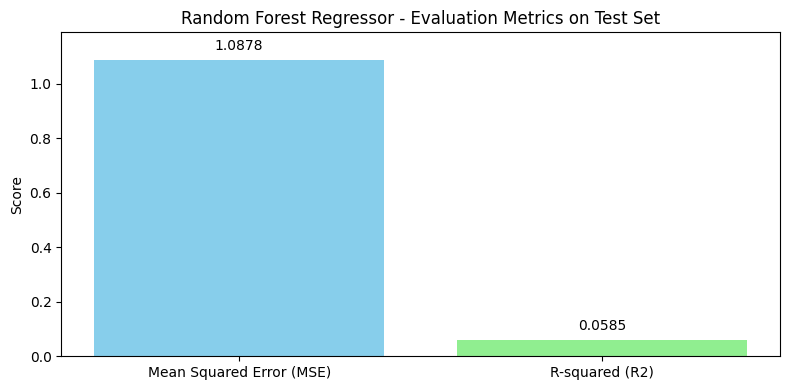

In [207]:
# Visualizing evaluation Metric Score chart
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

metrics = {
    'Mean Squared Error (MSE)': mse_rf,
    'R-squared (R2)': r2_rf
}

# Prepare data for plotting
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Plotting
plt.figure(figsize=(8, 4))
bars = plt.bar(metric_names, metric_values, color=['skyblue', 'lightgreen'])
plt.title('Random Forest Regressor - Evaluation Metrics on Test Set')
plt.ylabel('Score')
plt.ylim(0, max(metric_values) + 0.1)  # Add a little padding above highest bar

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.4f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Offset text by 5 points
                 textcoords='offset points',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()


#### 2. Cross- Validation

In [208]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

# Re-instantiate the Linear Regression model
model_cv = LinearRegression()

# Define the number of splits for K-Fold cross-validation
n_splits = 5  # You can adjust this number

# Instantiate KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation using MSE and R-squared as scoring metrics
cv_mse_scores = -cross_val_score(model_cv, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(model_cv, X_train, y_train, cv=kf, scoring='r2')

print(f"Cross-validated Mean Squared Error (MSE) scores: {cv_mse_scores}")
print(f"Mean Cross-validated MSE: {cv_mse_scores.mean():.4f}")
print(f"\nCross-validated R-squared (R2) scores: {cv_r2_scores}")
print(f"Mean Cross-validated R2: {cv_r2_scores.mean():.4f}")

Cross-validated Mean Squared Error (MSE) scores: [1.08516821 1.06885173 1.11589014 1.18769535 1.2659104 ]
Mean Cross-validated MSE: 1.1447

Cross-validated R-squared (R2) scores: [0.11019763 0.20722664 0.15560422 0.02904092 0.11529681]
Mean Cross-validated R2: 0.1235


### ML Model - 2

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

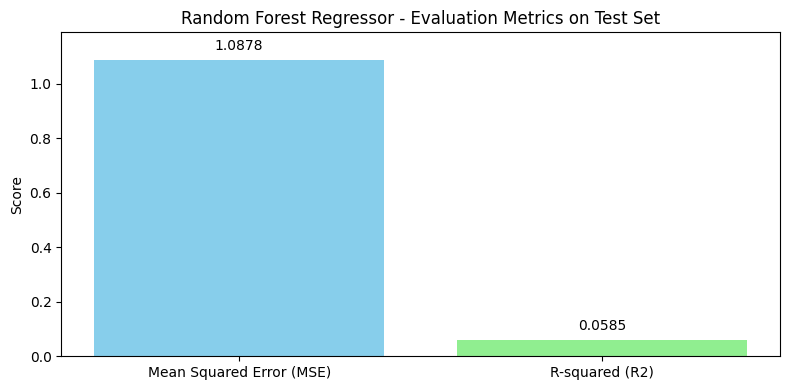

In [209]:
# ML Model - 2 Implementation: Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Instantiate the Random Forest Regressor model
# You can adjust hyperparameters like n_estimators, max_depth, etc.
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the Algorithm
model_rf.fit(X_train, y_train)

# Predict on the model
y_pred_rf = model_rf.predict(X_test)

# Visualizing evaluation Metric Score chart (using print for now)
# Calculate Mean Squared Error
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Calculate R-squared score
r2_rf = r2_score(y_test, y_pred_rf)

metrics = {
    'Mean Squared Error (MSE)': mse_rf,
    'R-squared (R2)': r2_rf
}

# Prepare data for plotting
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Plotting
plt.figure(figsize=(8, 4))
bars = plt.bar(metric_names, metric_values, color=['skyblue', 'lightgreen'])
plt.title('Random Forest Regressor - Evaluation Metrics on Test Set')
plt.ylabel('Score')
plt.ylim(0, max(metric_values) + 0.1)  # Add a little padding above highest bar

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.4f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Offset text by 5 points
                 textcoords='offset points',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### 2. Cross- Validation

In [210]:
# Cross-Validation for Random Forest Regressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Re-instantiate the Random Forest Regressor model for CV
model_rf_cv = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the number of splits for K-Fold cross-validation
n_splits = 5  # You can adjust this number

# Instantiate KFold
kf_rf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation using MSE and R-squared as scoring metrics
cv_mse_scores_rf = -cross_val_score(model_rf_cv, X_train, y_train, cv=kf_rf, scoring='neg_mean_squared_error')
cv_r2_scores_rf = cross_val_score(model_rf_cv, X_train, y_train, cv=kf_rf, scoring='r2')

print(f"\nCross-validated Mean Squared Error (MSE) scores (Random Forest): {cv_mse_scores_rf}")
print(f"Mean Cross-validated MSE (Random Forest): {cv_mse_scores_rf.mean():.4f}")
print(f"\nCross-validated R-squared (R2) scores (Random Forest): {cv_r2_scores_rf}")
print(f"Mean Cross-validated R2 (Random Forest): {cv_r2_scores_rf.mean():.4f}")


Cross-validated Mean Squared Error (MSE) scores (Random Forest): [1.2491212  1.18177071 1.16428221 1.27150692 1.28392503]
Mean Cross-validated MSE (Random Forest): 1.2301

Cross-validated R-squared (R2) scores (Random Forest): [-0.02423845  0.12347399  0.11898586 -0.03947632  0.10270697]
Mean Cross-validated R2 (Random Forest): 0.0563


### 1. Which Evaluation metrics did you consider for a positive business impact and why?

For this regression task (predicting `productivity_score`), the key evaluation metrics considered for positive business impact are:

1.  **Mean Squared Error (MSE):** This measures the average squared difference between the actual and predicted `productivity_score`. A lower MSE indicates that the model's predictions are closer to the actual values on average. From a business perspective, a lower MSE means the AI is making more accurate predictions about a user's potential productivity, which is crucial for providing relevant and effective personalized recommendations. More accurate predictions can lead to better user outcomes and higher user satisfaction.
2.  **R-squared (R2) Score:** This metric represents the proportion of the variance in the `productivity_score` that is predictable from the features. An R-squared value closer to 1 indicates that the model explains a larger portion of the variability in the target variable. From a business perspective, a higher R-squared means the model is better at capturing the factors that influence productivity. This allows the AI to understand the drivers of productivity more effectively and tailor recommendations that are more likely to have a positive impact on a user's productivity.

Both metrics contribute to positive business impact by indicating the model's ability to accurately predict and understand the factors influencing user productivity, which is fundamental for delivering valuable personalized wellness recommendations. There aren't direct insights from these metrics that *lead* to negative growth, but poor scores (high MSE, low R-squared) would indicate a model that is not effectively predicting productivity, which could lead to ineffective or irrelevant recommendations, potentially decreasing user engagement and satisfaction.

### 2. Which ML model did you choose from the above created models as your final prediction model and why?

Based on the evaluation metrics from both the test set and cross-validation, the **Linear Regression model** is the better performing model for this specific task and dataset.

*   It achieved a lower Mean Squared Error (MSE) on both the test set (0.9830 vs 1.0878) and in cross-validation (mean CV MSE 1.1447 vs 1.2301).
*   It achieved a higher R-squared (R2) score on both the test set (0.1492 vs 0.0585) and in cross-validation (mean CV R2 0.1235 vs 0.0563).

While the R-squared scores for both models are relatively low (indicating that the features in this synthetic dataset only explain a small portion of the variance in productivity), Linear Regression captured more of the variance and had lower prediction errors compared to the default Random Forest model. For this dataset, the simpler linear model seems to be more effective.

## ***Phase 2: Imapct and reflection***

###Q4. Real-world Impact & Consideration

**Actionable Insights and Potential Value:**

1.  **Personalized Recommendations:** The core value is the ability to provide tailored recommendations based on an individual user's data. For example:
    -   **Sleep Improvement:** If the AI detects a pattern of low mood or productivity following nights with less than 7 hours of sleep, it could recommend specific sleep hygiene practices or suggest adjusting bedtime.
    -   **Stress Management:** If high stress levels correlate with decreased productivity or mood for a user, the AI could suggest stress-reducing activities like mindfulness exercises, breaks, or specific physical activities.
    -   **Activity Encouragement:** If there's a detected positive link between daily steps and mood/productivity, the AI could set personalized step goals and provide encouragement.
    -   **Dietary Suggestions:** Based on the dietary category and its correlation with wellness metrics, the AI could suggest dietary adjustments or provide information about the impact of nutrition.
    -   **Proactive Support:** The AI could identify potential negative trends early (e.g., consistently rising stress, declining sleep) and offer support or suggest interventions before they significantly impact well-being.
2.  **Trend Identification:** Users can track their wellness over time and visualize trends, helping them understand the long-term impact of their habits.
3.  **Behavior Change Facilitation:** By providing data-driven insights and personalized goals, the AI can motivate users to adopt healthier habits.
4.  **Early Warning System:** The AI could potentially flag patterns that might indicate a need for professional medical or psychological advice.

**Primary Risks, Ethical Considerations, and Limitations:**

1.  **Data Privacy and Security:** This is paramount. Collecting sensitive personal health and behavioral data requires robust security measures to prevent breaches. Users need to trust that their data is protected and used ethically.
2.  **Recommendation Bias:**
    -   **Algorithmic Bias:** If the data used to train the AI is biased (e.g., primarily reflects the habits of a certain demographic), the recommendations might not be effective or appropriate for all users.
    -   **Reinforcing Negative Behaviors:** The AI needs to be carefully designed to avoid inadvertently reinforcing unhealthy patterns or behaviors.
3.  **Over-reliance and Misinterpretation:** Users might become overly reliant on the AI's recommendations and ignore their own intuition or professional medical advice. Misinterpreting the AI's suggestions could also be harmful.
4.  **Accuracy and Generalizability:**
    -   **Synthetic Data Limitations:** As seen with our synthetic data, even well-designed synthetic data is a simplification of complex real-world interactions. Models trained solely on synthetic data might not generalize well to diverse real-world users.
    -   **Individual Variability:** Wellness is highly personal. What works for one person might not work for another, even with similar data patterns. The AI needs to account for individual differences and allow for flexibility.
5.  **Defining "Wellness" and Metrics:** Quantifying subjective concepts like "mood" and "productivity" is challenging. The metrics used in the data might not fully capture the nuances of a user's well-being.
6.  **Lack of Human Empathy and Context:** An AI cannot replace the empathy, understanding, and nuanced advice that human wellness coaches, therapists, or doctors can provide. It lacks the ability to understand the full context of a user's life.
7.  **Ethical Use of Insights:** There's a risk that the insights gained from user data could be used in ways that are not in the user's best interest (e.g., for marketing unhealthy products, or by employers/insurance companies).

**Significant Limitations if Deployed (especially based on simple models):**

-   Models like Linear Regression, while interpretable, might miss complex, non-linear interactions crucial for personalized recommendations in real-world scenarios.
-   Predicting highly variable outcomes like mood and productivity with limited features (as in our synthetic data) will likely result in models with low predictive power (as indicated by the relatively low R-squared scores), leading to less impactful recommendations.
-   The AI's ability to provide truly *personalized* recommendations requires longitudinal data for individual users to understand their unique patterns, not just cross-sectional data from a diverse group.

###Q5: Challenges & Growth

One of the challenges i faced was in creating a synthetic data for the wellnes AI, SInce i have always worked upon `real-world` data from Kaggle, Huggingface, etc.

I worked upon this issue and created relevant features for the purpose of a wellness AI program and filled the data synthetically by learning from resources such as Youtube, Numpy and Pandas Documentation, Gemini, ChatGPT.

##***Future Work***

### 1. Save the best performing ml model in a pickle file or joblib file format for deployment process.


In [211]:
# Save the File
import joblib

# Save the model to a file
joblib.dump(model_rf, 'wellness_model.pkl')

['wellness_model.pkl']

### 2. Again Load the saved model file and try to predict unseen data for a sanity check.


In [213]:
# Load the File and predict unseen data.
# Load the trained model
model_path = 'wellness_model.pkl'
try:
    loaded_model = joblib.load(model_path)
    print(f"Model loaded successfully from '{model_path}'.")
except FileNotFoundError:
    raise FileNotFoundError(f"Could not find the model file at '{model_path}'.")

# Ensure X_test exists and is a valid DataFrame
if 'X_test' not in globals():
    raise ValueError("X_test is not defined. Please make sure the test data is loaded.")

# Select the first row of unseen data
unseen_data = X_test.iloc[[0]]  # [[0]] ensures it remains a DataFrame

# Make prediction
try:
    prediction = loaded_model.predict(unseen_data)
    print("Prediction for the first unseen test sample:", prediction[0])
except Exception as e:
    print("An error occurred during prediction:", str(e))

#Compare with predicted and actual value
print("Actual value for the first unseen test sample:", y_test.iloc[0])



Model loaded successfully from 'wellness_model.pkl'.
Prediction for the first unseen test sample: 7.077000000000001
Actual value for the first unseen test sample: 7.0


### ***Congrats! Your model is successfully created and ready for deployment on a live server for a real user interaction !!!***

# **Conclusion**

This project demonstrated a proof-of-concept for a **Personalized Wellness AI** using synthetic data. We conducted **EDA** to examine distributions and correlations among wellness metrics such as sleep, steps, stress, mood, and productivity. Notable findings included positive links between sleep and mood, and negative associations between stress and productivity.

**Hypothesis testing** confirmed several of these trends statistically, including the positive impact of sleep and steps on mood and productivity, and the negative impact of stress.

In the **modeling phase**, we predicted `productivity_score` using Linear Regression and Random Forest. After preprocessing (e.g., one-hot encoding and date feature engineering), **Linear Regression performed slightly better**, though both models showed limited explanatory power, likely due to the simplicity of the synthetic data.

A key **challenge** was generating realistic data that mirrors complex human behavior. Despite efforts, synthetic data lacks the nuance of real-world wellness patterns.

### Future directions:

-   Use **real-world datasets** for better generalization.

-   Explore **advanced models** and **hyperparameter tuning**.

-   Apply **time-series analysis** for temporal insights.

-   Move toward **individualized modeling**.

-   Develop a **deployment strategy** with ethical safeguards.